In [1]:
#All imports

import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Reading and Understanding**

In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Train.csv', index_col='ID')
train_df.head()

,Datetime,Count
ID,,
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2


In [4]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AV_TimeSeriesAnalysis/Test.csv')
test_df.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18288 entries, 0 to 18287
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  18288 non-null  object
 1   Count     18288 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 428.6+ KB


In [6]:
#converting the datetime column from object to datetime
train_df['Datetime'] = pd.to_datetime(train_df['Datetime'], format="%d-%m-%Y %H:%M", errors="coerce").fillna(pd.to_datetime(train_df['Datetime'], format="%d/%m/%Y %H:%M", errors="coerce"))

In [7]:
#check if time values are equally spaced
time_shift = train_df['Datetime'].shift(1)
time_diff = train_df['Datetime'] - time_shift
time_diff.value_counts()

0 days 01:00:00    18287
Name: Datetime, dtype: int64

**Considering univariate time series**

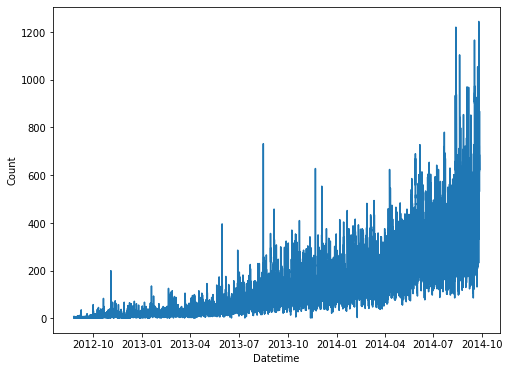

In [8]:
plt.figure(figsize=(8,6))
sns.lineplot(x=train_df['Datetime'], y=train_df['Count'])
plt.show()

In [9]:
#extract more features for visualization
train_df['year'] = train_df['Datetime'].dt.year
train_df['month'] = train_df['Datetime'].dt.month
train_df['week'] = train_df['Datetime'].dt.weekofyear

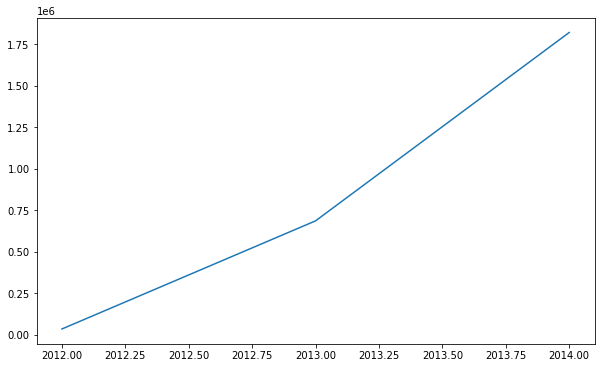

In [10]:
#visualize count of passengers year-wise
plt.figure(figsize=(10,6))
count_by_year = train_df[['year', 'Count']].groupby(by=['year']).sum()
plt.plot(count_by_year)

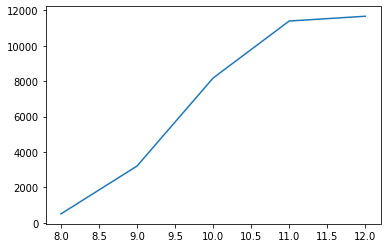

In [11]:
#visualize passengers count month-wise for each year
count_by_month_2012 = train_df[train_df['year'] == 2012][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2012)

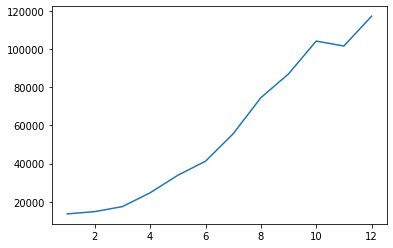

In [12]:
count_by_month_2013 = train_df[train_df['year'] == 2013][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2013)

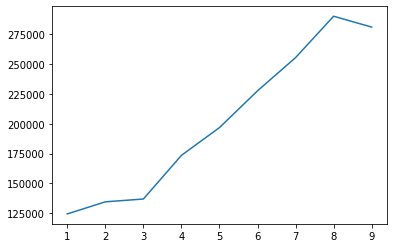

In [13]:
count_by_month_2014 = train_df[train_df['year'] == 2014][['month', 'Count']].groupby(by=['month']).sum()
plt.plot(count_by_month_2014)

**From plots above, there is a coninous increasing trend in passangers**

**Modelling**

In [14]:
X = train_df['Datetime']
y = train_df['Count']

split_index = int(len(train_df)*0.80)
X_train, y_train = X[0:split_index], y[0:split_index]
X_val, y_val = X[split_index:] , y[split_index:]

**Baseline model - Naive Forecast**

In [ ]:
y_val_pred = y[split_index-1:-1]

print("rmse: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_test = np.ones(len(test_df)) * y.iloc[-1]

rmse:  72.73801637926756


**Moving Average**

In [ ]:
y_val_pred = pd.Series(np.zeros(len(y_val)))

for i in range(len(y_val_pred)):
  y_val_pred[i] = y_train.append(y_val_pred[:i]).rolling(30).mean().iloc[-1]

print("rmse: ", np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_test = pd.Series(np.zeros(len(test_df)))
for i in range(len(test_df)):
  y_test[i] = y.append(y_test[:i]).rolling(30).mean().iloc[-1]

rmse:  210.41288514006956


**ARIMA to capture trend**

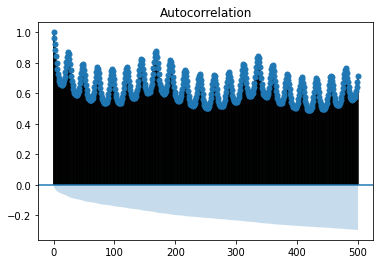

In [ ]:
plot_acf(y, lags=500)
plt.show()

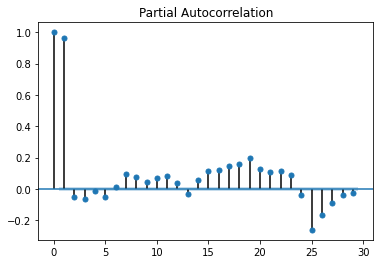

In [ ]:
plot_pacf(y, lags=29)
plt.show()

In [ ]:
#walk-forward validation
def evaluate_arima(order):
  y_val_predictions = []
  y_train_flt = y_train.astype('float64')
  history = [x for x in y_train_flt]
  for i in range(len(y_val)):
    model = ARIMA(history, order)
    model_fit = model.fit()  
    y_val_predictions.append(model_fit.forecast()[0])

    history.append(y_val[split_index + i])
  
  rmse = np.sqrt(mean_squared_error(y_val, y_val_predictions))
  print ("order: {} rmse: {}".format(order, rmse))

  return rmse

**From ACF and PACF plots considering order (1,1,0)**

In [ ]:
evaluate_arima((1,1,0))

order: (1, 1, 0) rmse: 72.88959297178528


72.88959297178528

In [15]:
#Building a final ARIMA 
final_model = ARIMA(y, order=(1,1,0))
final_model = final_model.fit()

print (final_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Count   No. Observations:                18287
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -93866.213
Method:                       css-mle   S.D. of innovations             41.018
Date:                Wed, 07 Apr 2021   AIC                         187738.425
Time:                        09:05:31   BIC                         187761.867
Sample:                             1   HQIC                        187746.128
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0288      0.313      0.092      0.927      -0.584       0.641
ar.L1.D.Count     0.0294      0.007      3.977      0.000       0.015       0.044
                                    Root

In [ ]:
#Test predictions
y_test = final_model.forecast(steps=len(test_df))[0]

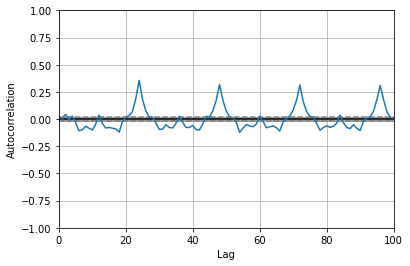

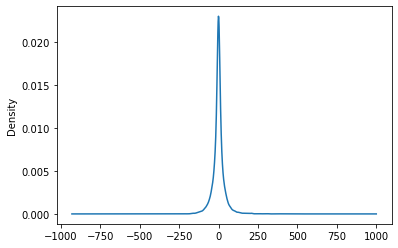

In [ ]:
residuals = final_model.resid

autocorrelation_plot(residuals).set_xlim([0,100])
plt.show()

residuals.plot(kind='kde')
plt.show()

**Test submission**

In [ ]:
test_predictions = pd.DataFrame({'ID':test_df['ID'], 'Count':y_test})
test_predictions.to_csv('./submission.csv', index=False)